**Лабораторная работа #6 (2).**

Используя явную и неявную схемы, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x, t)$. Исследовать зависимость погрешности от сеточных параметров $𝜏, h$.

$\frac{\partial^2 u}{\partial t^2} + 2\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + 2\frac{\partial u}{\partial x} - 3u,$

$u(0, t) = 0,$

$u(\pi, t) = 0,$

$u(x, 0) = 0,$

$u_t(x, 0) = 2e^{-x}\sin{x}$

Аналитическое решение: $U(x, t) = e^{-t-x}\sin{x}\sin{2t}$

In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def analytic_solution(x, t):
    return np.exp(-t - x) * np.sin(x) * np.sin(2 * t)

def phi0(t):
    return 0

def phi1(t):
    return 0

def psi1(x):
    return 0

def psi2(x):
    return 2 * np.exp(-x) * np.sin(x)

In [129]:
t_max = 1
count_x = 50
count_t = 1000
r_coord = np.pi
a = 1
b = 2
c = -3
e = 2
h = r_coord / count_x
tau = t_max / count_t
# число Куранта
sigma = a * tau / (h**2)

In [130]:
def show_result(t_axis, x_axis, u1, u2):
    times_to_plot = [0.2, 0.5, 1.0]
    indices_to_plot = [np.argmin(np.abs(t_axis - time)) for time in times_to_plot]

    plt.figure(figsize=(10, 6))  # Размер графика

    for i, index in enumerate(indices_to_plot):
        plt.plot(x_axis, u1[index, :], label=f"Явная схема, t = {t_axis[index]:.1f}")
        plt.plot(x_axis, u2[index, :], label=f"Неявная схема, t = {t_axis[index]:.1f}")
        plt.plot(x_axis, [analytic_solution(x, t_axis[index]) for x in x_axis], label=f"Аналитическое решение, t = {t_axis[index]:.1f}", linestyle='--')


    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title("Сравнение численных и аналитического решений")
    plt.legend()
    plt.show()


def show_inaccuracy(t_axis, x_axis, u1, u2):
    inaccuracy1 = np.zeros(len(t_axis))
    inaccuracy2 = np.zeros(len(t_axis))

    for i in range(len(t_axis)):
        inaccuracy1[i] = np.max(np.abs(u1[i, :] - np.array([analytic_solution(x, t_axis[i]) for x in x_axis])))
        inaccuracy2[i] = np.max(np.abs(u2[i, :] - np.array([analytic_solution(x, t_axis[i]) for x in x_axis])))

    plt.figure(figsize=(10, 6))
    plt.plot(t_axis[1:], inaccuracy1[1:], "violet", label="Ошибка (явная схема)") #Сдвиг на 1 для удаления нулевого значения
    plt.plot(t_axis[1:], inaccuracy2[1:], "blue", label="Ошибка (неявная схема)") #Сдвиг на 1 для удаления нулевого значения
    print('Максимальная ошибка явной схемы: ', np.max(inaccuracy1[1:]))
    print('Максимальная ошибка неявной схемы: ', np.max(inaccuracy2[1:]))
    plt.legend()
    plt.title("График изменения ошибки во времени")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.grid(True)
    plt.show()

In [131]:
def explicit_scheme(bound_condition, initial_condition):
    u = np.zeros((count_t, count_x))

    for i in range(0, count_x):
        u[0][i] = psi1(i * h)

        if initial_condition == 1:
            u[1][i] = psi1(i * h) + psi2(i * h) * tau + 0
        elif initial_condition == 2:
            u[1][i] = (
                psi1(i * h)
                + tau * psi2(i * h)
                + 0.5 * (tau**2) * (-e * psi2(i * h) + c * psi1(i * h))
            )
        else:
            print("Approximation type not found")

    for k in range(2, count_t):
        for i in range(1, count_x - 1):
            u[k][i] = (
                4 * u[k - 1][i]
                + (e * tau - 2) * u[k - 2][i]
                + 2
                * a
                * (tau**2)
                * (u[k - 1][i - 1] - 2 * u[k - 1, i] + u[k - 1][i + 1])
                / (h**2)
                + b * (tau**2) * (u[k - 1][i + 1] - u[k - 1][i - 1]) / h
                + 2 * (tau**2) * (c * u[k - 1][i])
            ) / (2 + e * tau)
        if bound_condition == 1:
            u[k][0] = 0
            u[k][-1] = 0
        elif bound_condition == 2:
            u[k][0] = (phi0(k * tau) + u[k][2] / (2 * h) - 2 * u[k][1] / h) * 2 * h / -3
            u[k][-1] = phi1(k * tau)
        elif bound_condition == 3:
            u[k][0] = 2 * h * phi1(k * tau)
            u[k][-1] = 2 * h * phi1(k * tau)
        else:
            print("Условие не найдено")

    return u

def implicit_scheme(bound_condition, initial_condition):
    u = np.zeros((count_t, count_x))

    ai = np.zeros(count_x)
    bi = np.zeros(count_x)
    ci = np.zeros(count_x)
    di = np.zeros(count_x)

    for i in range(0, count_x):
        u[0][i] = psi1(i * h)

        if initial_condition == 1:
            u[1][i] = psi1(i * h) + psi2(i * h) * tau
        elif initial_condition == 2:
            u[1][i] = (
                psi1(i * h)
                + tau * psi2(i * h)
                + 0.5 * (tau**2) * (-e * psi2(i * h) + c * psi1(i * h))
            )
        else:
            print("Условие не найдено")

    for k in range(2, count_t):
        for i in range(1, count_x - 1):
            ai[i] = 2 * a - h * b
            bi[i] = 2 * (h**2) * (-e / (2 * tau) - 1 / (tau**2) + c) - 4 * a
            ci[i] = h * b + 2 * a
            di[i] = (
                -4 * (h**2) * u[k - 1][i] / (tau**2)
                + (2 * (h**2) / (tau**2) - e * (h**2) / tau) * u[k - 2][i]
            )

        if bound_condition == 1:
            bi[0] = h
            ci[0] = 0
            di[0] = h * phi0(k * tau)
            ai[-1] = 2 * sigma
            bi[-1] = -(1 + 2 * sigma - c * tau)
            di[-1] = -phi1(k * tau)
        elif bound_condition == 2:
            bi[0] = -(1 + 2 * sigma - c * tau)
            ci[0] = 2 * sigma
            di[0] = -(u[k - 1][0] - 2 * a * tau * phi0(k * tau) / h)
            ai[-1] = 2 * sigma
            bi[-1] = -(1 + 2 * sigma - c * tau)
            di[-1] = -phi1(k * tau)
        elif bound_condition == 3:
            bi[0] = -(1 + 2 * sigma - c * tau)
            ci[0] = 2 * sigma
            di[0] = -(
                (1 - sigma) * u[k - 1][1] + sigma / 2 * u[k - 1][0]
            ) - sigma * phi0(k * tau)
            ai[-1] = 2 * sigma
            bi[-1] = -(1 + 2 * sigma - c * tau)
            di[-1] = -phi1(k * tau)
        else:
            print("Условие не найдено")

        u[k] = progonka(ai, bi, ci, di)

    return u

def progonka(a, b, c, d):
    size = len(a)
    p = np.zeros(size)
    q = np.zeros(size)
    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, size):
        s = b[i] + a[i] * p[i - 1]
        p[i] = -c[i] / s
        q[i] = (d[i] - a[i] * q[i - 1]) / s

    result = np.zeros(size)
    result[-1] = q[-1]

    for i in range(size - 2, -1, -1):
        result[i] = p[i] * result[i + 1] + q[i]

    return result

def get_axis_np(count, mul):
    axis = np.zeros(count)
    for i in range(count):
        axis[i] = mul * i
    return axis

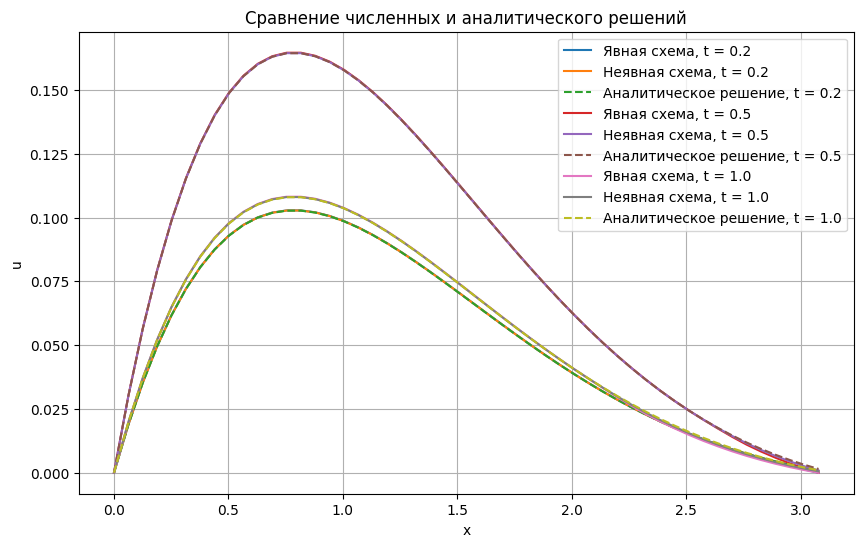

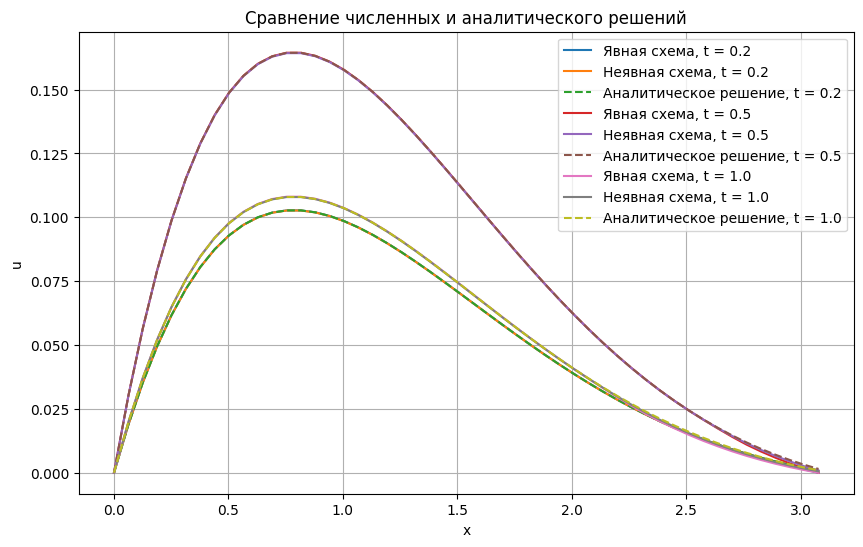

Максимальная ошибка явной схемы:  0.0014857158519662149
Максимальная ошибка неявной схемы:  0.000629319401597


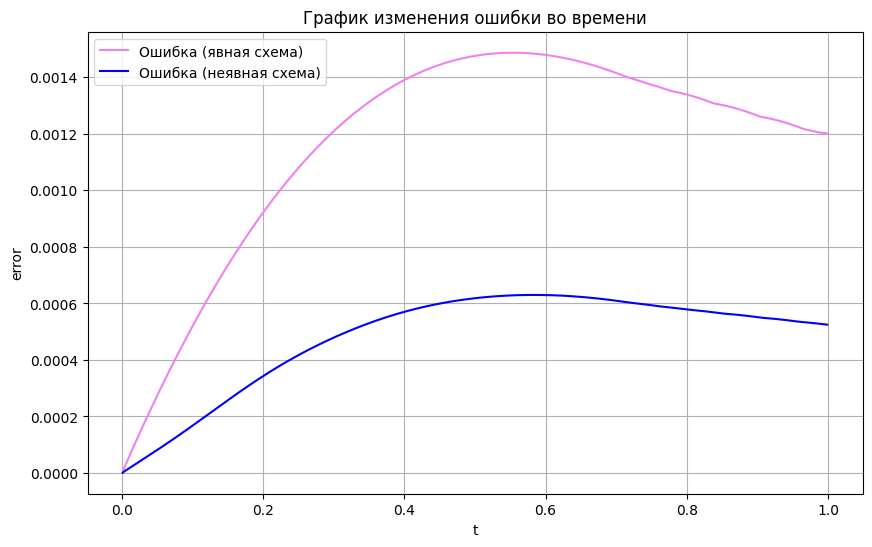

Максимальная ошибка явной схемы:  0.0014857158519662149
Максимальная ошибка неявной схемы:  0.0006301726459389103


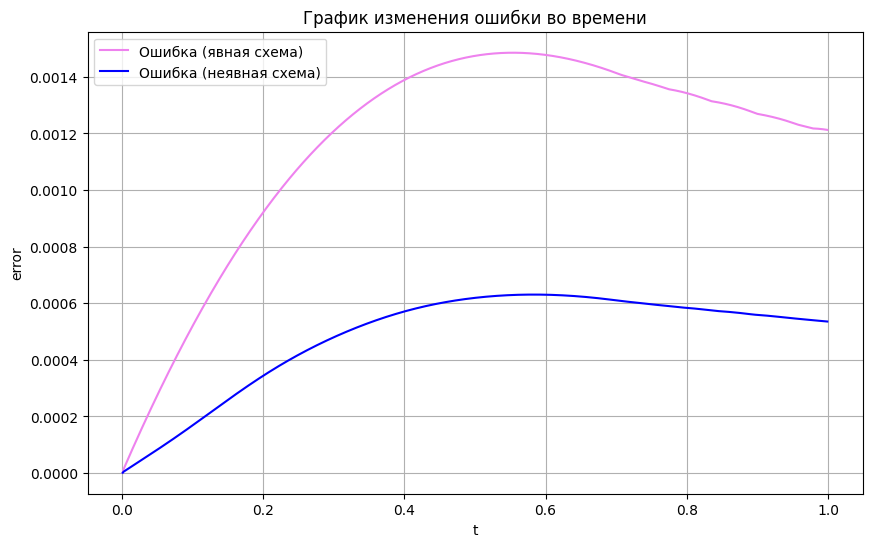

In [132]:
res1 = explicit_scheme(1, 1)
res2 = implicit_scheme(1, 1)
res1_2 = explicit_scheme(1, 2)
res2_2 = implicit_scheme(1, 2)

t_axis = get_axis_np(count_t, tau)
x_axis = get_axis_np(count_x, h)

show_result(t_axis, x_axis, res1, res2)
show_result(t_axis, x_axis, res1_2, res2_2)
show_inaccuracy(t_axis, x_axis, res1, res2)
show_inaccuracy(t_axis, x_axis, res1_2, res2_2)